<a href="https://colab.research.google.com/github/VenunathR/Code-Red/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import data
and begin feature engineering

In [61]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

# Load the datasets
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

# Concatenate train and test data
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Separate the combined dataframe back into training and testing sets
# based on the presence of the 'WeightCategory' column
df_train_split = df_all[df_all['WeightCategory'].notna()].copy()
df_test_split = df_all[df_all['WeightCategory'].isna()].copy()

# Separate features (X) and target (y) in the training data
X_train = df_train_split.drop('WeightCategory', axis=1)
y_train = df_train_split['WeightCategory']

# Separate features (X) in the test data
X_test = df_test_split.drop('WeightCategory', axis=1)


# Identify categorical and numerical features in the original data
cat_feats = X_train.select_dtypes(include='object').columns.tolist()
num_feats = X_train.select_dtypes(include=[np.number]).columns.drop('id').tolist()

# Apply one-hot encoding to categorical features separately for test
X_test_processed = pd.get_dummies(X_test, columns=cat_feats)

# Initialize and fit a StandardScaler on the training data
scaler = StandardScaler()
X_train_processed_scaled_num = scaler.fit_transform(X_train[num_feats])

# Apply standard scaling to numerical features separately for test using the *same* scaler fitted on the train data
X_test_processed[num_feats] = scaler.transform(X_test_processed[num_feats])

# One-hot encode training data to get all columns
X_train_processed = pd.get_dummies(X_train, columns=cat_feats)
X_train_processed[num_feats] = X_train_processed_scaled_num

# Align columns between training and test sets after one-hot encoding
train_cols = X_train_processed.columns
test_cols = X_test_processed.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_processed[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_test_processed = X_test_processed.drop(c, axis=1)


X_test_processed = X_test_processed[train_cols]

display(X_test_processed.head())

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,...,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
15533,15533,-0.849222,0.827343,1.898772,1.049363,0.339130,-0.033368,0.584315,0.331153,True,...,True,False,False,True,False,False,False,False,True,False
15534,15534,-0.396292,-0.017934,-0.484871,-0.834311,0.339130,-0.045459,0.718028,2.079095,True,...,True,False,False,True,False,False,False,False,True,False
15535,15535,-0.270402,0.428151,-0.219401,-0.834311,-0.056315,-0.324186,-0.628525,-1.019279,False,...,True,False,False,True,False,False,False,False,True,False
15536,15536,1.253777,0.863057,1.254353,0.508272,0.339130,0.192100,-0.315771,-0.853143,False,...,True,False,False,True,False,True,False,False,False,False
15537,15537,-1.027075,-0.341270,-0.864114,-0.834311,0.339130,-0.045459,0.027524,0.641290,True,...,True,False,False,False,True,False,False,False,True,False


do data encoding

In [62]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

display(y_train_encoded[:5])

array([6, 1, 0, 4, 6])

## Split training data for validation




In [63]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets for early stopping
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_processed, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

display(X_train_part.head())
display(X_val.head())
display(y_train_part[:5])
display(y_val[:5])

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,...,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
7417,7417,-1.203660,0.000933,-0.105628,1.049363,0.339130,-0.045459,1.222532,0.641290,False,...,True,False,False,True,False,False,False,False,False,True
15351,15351,-1.006189,0.583443,-1.210012,-0.834311,0.476966,-0.660113,1.222532,1.140609,True,...,True,False,False,True,False,False,False,False,True,False
1230,1230,-0.055635,-1.155577,-1.636186,0.912625,-2.491966,-1.626282,-1.159060,0.600612,True,...,True,False,False,False,True,False,False,False,True,False
2344,2344,-1.027075,1.669630,-1.295670,-0.834311,0.339130,-0.045459,1.222532,0.641290,False,...,True,False,False,False,True,False,False,False,True,False
3487,3487,-0.320733,-0.569405,-0.674493,-0.834311,-2.491966,-0.045459,-1.167485,2.301858,False,...,True,False,False,True,False,False,False,False,True,False


,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,...,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
12043,12043,1.189618,1.410183,1.570419,-0.534744,0.339130,0.211119,-0.109146,1.617780,False,...,True,False,False,True,False,False,False,False,True,False
4202,4202,-0.497319,-0.797541,-0.750341,1.049363,0.339130,-1.690972,0.027524,-1.019279,True,...,True,False,False,False,True,False,False,False,True,False
8603,8603,0.991240,0.861187,0.577679,0.982152,0.292543,0.023781,-0.477890,1.222653,False,...,True,False,False,True,False,False,False,False,True,False
2447,2447,-1.203660,-0.227202,-0.086666,-0.834311,-2.491966,1.600054,0.027524,0.641290,False,...,True,False,False,False,True,False,False,False,True,False
65,65,-1.027075,-0.797541,-1.432979,1.049363,1.754678,-0.045459,1.222532,0.641290,True,...,True,False,False,True,False,False,False,False,True,False


array([6, 0, 0, 0, 5])

array([3, 1, 3, 6, 0])

## Define and train xgboost model




In [64]:
# Define the parameters for the XGBoost model
xgb_params_0 = {
    'learning_rate': 0.0261,
    'n_estimators': 1500,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'early_stopping_rounds': 60,
    'max_depth': 18,
    'min_child_weight': 11.73,
    'gamma': 0.402,
    'colsample_bytree': 0.463,
    'random_state': 42,
    'subsample': 0.821,
    'reg_alpha': 0.00041,
    'verbosity': 0,
    'reg_lambda': 1.397,
}

# Initialize the XGBoost classifier with the specified parameters
xgb_model = XGBClassifier(**xgb_params_0)

# Train the XGBoost model with encoded target and processed features, using the validation set for early stopping
xgb_model.fit(X_train_part, y_train_part, eval_set=[(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.463, device=None, early_stopping_rounds=60,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.402,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0261, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=11.73, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, ...)

plot validation metrics

In [66]:
from sklearn.metrics import classification_report

# Make predictions on the validation set
y_val_pred = xgb_model.predict(X_val)

# Decode the validation predictions
y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)

# Decode the true validation labels
y_val_decoded = label_encoder.inverse_transform(y_val)

# Generate classification report for the validation set
report_val = classification_report(y_val_decoded, y_val_pred_decoded)

# Print the report
print("Classification Report on Validation Set:")
print(report_val)

Classification Report on Validation Set:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.94      0.94       374
      Normal_Weight       0.89      0.89      0.89       469
     Obesity_Type_I       0.89      0.88      0.88       441
    Obesity_Type_II       0.96      0.98      0.97       481
   Obesity_Type_III       0.99      1.00      0.99       597
 Overweight_Level_I       0.81      0.76      0.78       369
Overweight_Level_II       0.81      0.84      0.83       376

           accuracy                           0.91      3107
          macro avg       0.90      0.90      0.90      3107
       weighted avg       0.91      0.91      0.91      3107



plot confusionmatrix

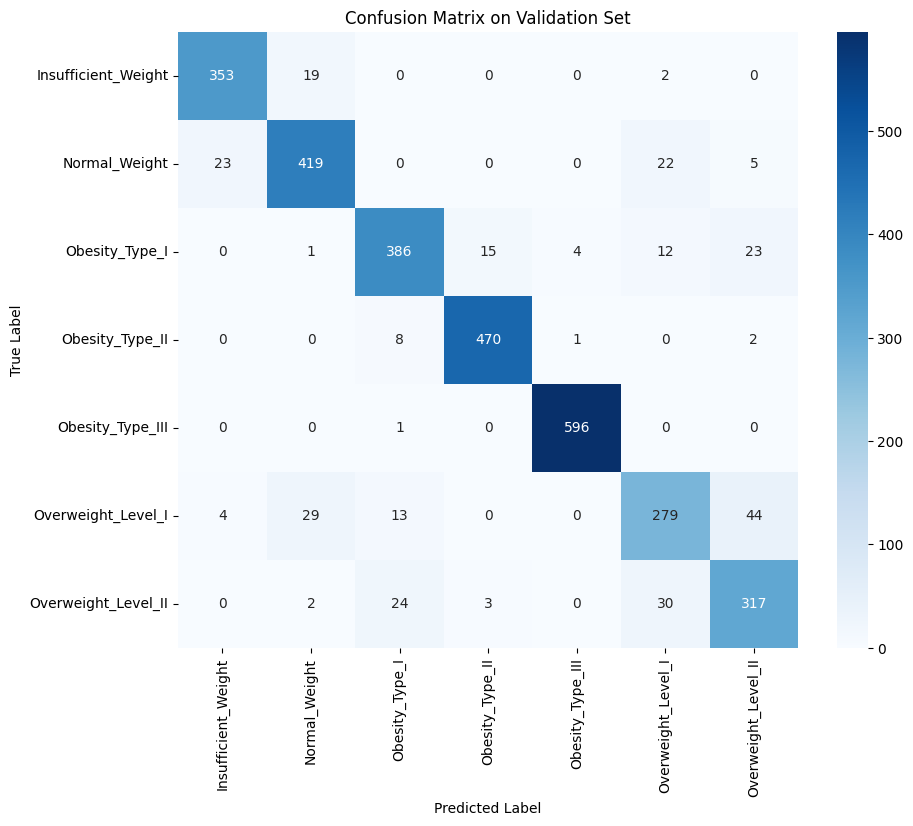

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Decode the true validation labels
y_val_decoded = label_encoder.inverse_transform(y_val)

# Decode the validation predictions (assuming y_val_pred_decoded is available and correct size)
# If y_val_pred_decoded is not available or incorrect size, you might need to regenerate it:
# y_val_pred = xgb_model.predict(X_val)
# y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred)


# Generate the confusion matrix
cm = confusion_matrix(y_val_decoded, y_val_pred_decoded)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.show()

## Decode predictions

### Subtask:
Decode the numerical predictions back to their original categorical labels.


In [58]:
# Decode the predictions back to their original categorical labels
predictions_decoded = label_encoder.inverse_transform(predictions)

display(predictions_decoded)

array(['Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II',
       ..., 'Obesity_Type_I', 'Overweight_Level_II', 'Obesity_Type_II'],
      dtype=object)

## Create submission file




In [60]:
# Create submission DataFrame
submission_df = pd.DataFrame({'id': df_test['id'], 'WeightCategory': predictions_decoded})

# Save submission file
submission_df.to_csv('submission.csv', index=False)

# Print confirmation message
print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
